In [1]:
#note: investing in financial markets is very complicated and should only be done by experienced people. The author declines all responsibility for any losses.

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

import keras
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

Download and Manage Financial Data
We download the data of the S&P 500 index from Yahoo Finance. Our analysis is monthly-based, and all the decisions are made the first trading day of the month. For this reason, we fix the convention that start_date will always be the first day of a month and end_date will always be the last day of a month.

Our analysis will start from 24 months after the month of start_date, since we will use the first 24 months to produce the two-years moving average.

In [2]:
start_date=datetime.datetime(1973, 1, 1)
end_date=datetime.datetime(2011,3,31)

In [5]:
df = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
df.drop("Adj Close",axis=1,inplace=True)
print(df.tail())

                   High          Low         Open        Close      Volume
Date                                                                      
2011-03-25  1319.180054  1310.150024  1311.800049  1313.800049  4223740000
2011-03-28  1319.739990  1310.189941  1315.449951  1310.189941  3215170000
2011-03-29  1319.449951  1305.260010  1309.369995  1319.439941  3482580000
2011-03-30  1331.739990  1321.890015  1321.890015  1328.260010  3809570000
2011-03-31  1329.770020  1325.030029  1327.439941  1325.829956  3566270000


In [6]:
#We need the list of the first trading day for each month, so we compute it:
start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

first_days=[]
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))
# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))
# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index))

<ipython-input-6-8d3aee463fbc>:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_days.append(min(df[str(start_year)+"-"+str(month)].index))
<ipython-input-6-8d3aee463fbc>:14: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_days.append(min(df[str(year)+"-"+str(month)].index))
<ipython-input-6-8d3aee463fbc>:17: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_days.append(min(df[str(end_year)+"-"+str(month)].index))


For each month we need the means of the month, the first trading day of the current month (and its open price), and the first trading day of the next month (and its open price): our models will predict based on these data.

The feature quot is the quotient between the open price of the first trading day of the next month and the open price of the first trading day of the current month. It will be useful because it gives the variation of the portfolio for the current month.

Finally we add the columns corresponding to the moving averages at 1 and 2 years.

In [7]:
def monthly_df(df):

    dfm=df.resample("M").mean()
    dfm=dfm[:-1] # As we said, we do not consider the month of end_date
    
    dfm["fd_cm"]=first_days[:-1]
    dfm["fd_nm"]=first_days[1:]
    dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
    dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
    dfm["quot"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])
    
    dfm["mv_avg_12"]= dfm["Open"].rolling(window=12).mean().shift(1)
    dfm["mv_avg_24"]= dfm["Open"].rolling(window=24).mean().shift(1)
    
    dfm=dfm.iloc[24:,:] # we remove the first 24 months, since they do not have the 2-year moving average
    
    return dfm

In [8]:
dfm=monthly_df(df)

print(dfm.head())
print(dfm.tail())

#each month of dfm contains the moving averages of the previous 12 and 24 months (excluding the current month)
print(dfm.loc["1980-03","mv_avg_12"])
print(dfm.loc["1979-03":"1980-02","Open"])
print(dfm.loc["1979-03":"1980-02","Open"].mean())

                 High        Low  Open      Close        Volume      fd_cm  \
Date                                                                         
1975-01-31  73.546817  71.442273   0.0  72.564091  1.966136e+07 1975-01-02   
1975-02-28  80.988421  78.892106   0.0  80.096842  2.229684e+07 1975-02-03   
1975-03-31  84.783500  82.723500   0.0  83.831999  2.268050e+07 1975-03-03   
1975-04-30  85.649999  83.705001   0.0  84.723182  2.051591e+07 1975-04-01   
1975-05-31  91.089047  89.058096   0.0  90.096190  2.178524e+07 1975-05-01   

                fd_nm  fd_cm_open  fd_nm_open  quot  mv_avg_12  mv_avg_24  
Date                                                                       
1975-01-31 1975-02-03         0.0         0.0   NaN        0.0        0.0  
1975-02-28 1975-03-03         0.0         0.0   NaN        0.0        0.0  
1975-03-31 1975-04-01         0.0         0.0   NaN        0.0        0.0  
1975-04-30 1975-05-01         0.0         0.0   NaN        0.0        0.0

In [9]:
def yield_gross(df,v):
    prod=(v*df["quot"]+1-v).prod()
    n_years=len(v)/12
    return (prod-1)*100,((prod**(1/n_years))-1)*100

In [10]:
tax_cg=0.26
comm_bk=0.001

In [11]:
def separate_ones(u):
    
    u_ = np.r_[0,u,0]
    i = np.flatnonzero(u_[:-1] != u_[1:])
    v,w = i[::2],i[1::2]
    if len(v)==0:
        return np.zeros(len(u)),0
    
    n,m = len(v),len(u)
    o = np.zeros(n*m,dtype=int)

    r = np.arange(n)*m
    o[v+r] = 1

    if w[-1] == m:
        o[w[:-1]+r[:-1]] = -1
    else:
        o[w+r] -= 1

    out = o.cumsum().reshape(n,-1)
    return out,n

In [12]:
#Let us clarify the behavior of this function with an example:

u=np.array([0,1,1,0,1,1,1,0,1])

In [13]:
separate_ones(u)

(array([[0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32),
 3)

In [14]:
def yield_net(df,v):
    n_years=len(v)/12
    
    w,n=separate_ones(v)
    A=(w*np.array(df["quot"])+(1-w)).prod(axis=1)  # A is the product of each group of ones of 1 for df["quot"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n)) 
    
    return (prod-1)*100,((prod**(1/n_years))-1)*100  

Define and Train the Two Deep Learning Models
We will use two deep learning models to forecast the S&P 500 index: one, called model_lstm, which will be composed of LSTM recurrent neural networks, and one called model_mix, which will be composed of both LSTM and one-dimensional convolutional layers.

The first step will be to preprocess the financial data we acquired. In particular we will:

create a window of data; recurrent neural networks take sequences as inputs and we will reshape the data accordingly. In particular, we will input to the model all data corresponding to the past six months.
scale the financial data in a range from 0 to 1, since recurrent neural networks work best with such data.
divide the data into a train set and a test set; the latter will be the set on which we will compare the trading strategies. By default we will set this set to be 72 months long.
Both our models will predict the value of the S&P 500 index for the first trading day of the following month, given all data of the past six months.

In [15]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [16]:
def data_to_model(dfm):
    scaler=MinMaxScaler(feature_range=(0,1))
    dg=pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Close","Volume","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))
    X=dg[[0,1,2,3,4,5,6,7]]
    X=create_window(X,window)
    X=np.reshape(X.values,(X.shape[0],window+1,8))
    
    y=np.array(dg[8][window:])
    
    return X,y

In [17]:
window=5

X,y=data_to_model(dfm)
print(X.shape,y.shape)

(429, 6, 8) (429,)


In [18]:
mtest=72

X_train=X[:-mtest-1,:,:]
X_test=X[-mtest-1:,:,:]
y_train=y[:-mtest-1]
y_test=y[-mtest-1:]

In [19]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200,  return_sequences=False)) # there is no need to specify input_shape here
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    return model

In [20]:
def model_mix(window,features):
    
    model=Sequential()
    model.add(Conv1D(input_shape=(window,features),filters=32,kernel_size=2,strides=1,activation='relu',padding='same'))
    model.add(Conv1D(filters=64,kernel_size=2,strides=1,activation='relu',padding='same'))
    model.add(LSTM(300, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200,  return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    return model

In [21]:
model_lstm=model_lstm(window+1,8)
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 300)            370800    
_________________________________________________________________
dropout (Dropout)            (None, 6, 300)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 791,801
Trainable params: 791,801
Non-trainable params: 0
__________________________________________________

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=25, verbose=1,\
                                                 factor=0.25, min_lr=0.00001)

In [24]:
history_lstm=model_lstm.fit(X_train,y_train,epochs=400, batch_size=24, validation_data=(X_test, y_test), \
                  verbose=1, callbacks=[learning_rate_reduction],shuffle=False)

Epoch 1/400
15/15 [==============================] - 11s 209ms/step - loss: 0.0535 - val_loss: 0.5709
Epoch 2/400
15/15 [==============================] - 1s 67ms/step - loss: 0.0052 - val_loss: 0.0234
Epoch 3/400
15/15 [==============================] - 1s 66ms/step - loss: 0.0094 - val_loss: 0.0145
Epoch 4/400
15/15 [==============================] - 1s 67ms/step - loss: 0.0101 - val_loss: 0.0183
Epoch 5/400
15/15 [==============================] - 1s 66ms/step - loss: 0.0264 - val_loss: 0.0067
Epoch 6/400
15/15 [==============================] - 1s 71ms/step - loss: 0.0118 - val_loss: 0.1587
Epoch 7/400
15/15 [==============================] - 1s 69ms/step - loss: 0.0402 - val_loss: 0.2701
Epoch 8/400
15/15 [==============================] - 1s 74ms/step - loss: 0.0027 - val_loss: 0.0122
Epoch 9/400
15/15 [==============================] - 1s 73ms/step - loss: 0.0017 - val_loss: 0.0106
Epoch 10/400
15/15 [==============================] - 1s 66ms/step - loss: 0.0015 - val_loss: 0.01

15/15 [==============================] - 1s 59ms/step - loss: 7.9894e-04 - val_loss: 0.0072
Epoch 80/400
15/15 [==============================] - 1s 57ms/step - loss: 8.0111e-04 - val_loss: 0.0072

Epoch 00080: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 81/400
15/15 [==============================] - 1s 60ms/step - loss: 8.6304e-04 - val_loss: 0.0072
Epoch 82/400
15/15 [==============================] - 1s 61ms/step - loss: 9.4995e-04 - val_loss: 0.0072
Epoch 83/400
15/15 [==============================] - 1s 59ms/step - loss: 8.4861e-04 - val_loss: 0.0072
Epoch 84/400
15/15 [==============================] - 1s 66ms/step - loss: 0.0010 - val_loss: 0.0072
Epoch 85/400
15/15 [==============================] - 1s 59ms/step - loss: 8.7997e-04 - val_loss: 0.0072
Epoch 86/400
15/15 [==============================] - 1s 59ms/step - loss: 8.3913e-04 - val_loss: 0.0072
Epoch 87/400
15/15 [==============================] - 1s 65ms/step - loss: 7.3990e-04 - val_los

15/15 [==============================] - 1s 69ms/step - loss: 6.9522e-04 - val_loss: 0.0067
Epoch 156/400
15/15 [==============================] - 1s 68ms/step - loss: 8.1185e-04 - val_loss: 0.0067
Epoch 157/400
15/15 [==============================] - 1s 83ms/step - loss: 8.4255e-04 - val_loss: 0.0067
Epoch 158/400
15/15 [==============================] - 1s 70ms/step - loss: 8.4988e-04 - val_loss: 0.0067
Epoch 159/400
15/15 [==============================] - 1s 69ms/step - loss: 8.3715e-04 - val_loss: 0.0067
Epoch 160/400
15/15 [==============================] - 1s 69ms/step - loss: 8.8337e-04 - val_loss: 0.0066
Epoch 161/400
15/15 [==============================] - 1s 65ms/step - loss: 9.8035e-04 - val_loss: 0.0066
Epoch 162/400
15/15 [==============================] - 1s 60ms/step - loss: 8.5185e-04 - val_loss: 0.0066
Epoch 163/400
15/15 [==============================] - 1s 64ms/step - loss: 7.9559e-04 - val_loss: 0.0066
Epoch 164/400
15/15 [==============================] - 1s 63

15/15 [==============================] - 1s 59ms/step - loss: 7.5177e-04 - val_loss: 0.0061
Epoch 233/400
15/15 [==============================] - 1s 60ms/step - loss: 0.0010 - val_loss: 0.0061
Epoch 234/400
15/15 [==============================] - 1s 101ms/step - loss: 7.3450e-04 - val_loss: 0.0061
Epoch 235/400
15/15 [==============================] - 1s 91ms/step - loss: 7.9216e-04 - val_loss: 0.0061
Epoch 236/400
15/15 [==============================] - 1s 75ms/step - loss: 7.9126e-04 - val_loss: 0.0060
Epoch 237/400
15/15 [==============================] - 1s 56ms/step - loss: 7.9835e-04 - val_loss: 0.0060
Epoch 238/400
15/15 [==============================] - 1s 60ms/step - loss: 8.1637e-04 - val_loss: 0.0061
Epoch 239/400
15/15 [==============================] - 1s 61ms/step - loss: 7.4343e-04 - val_loss: 0.0060
Epoch 240/400
15/15 [==============================] - 1s 63ms/step - loss: 8.7605e-04 - val_loss: 0.0060
Epoch 241/400
15/15 [==============================] - 1s 70ms/

15/15 [==============================] - 1s 56ms/step - loss: 7.0907e-04 - val_loss: 0.0054
Epoch 310/400
15/15 [==============================] - 1s 60ms/step - loss: 6.3140e-04 - val_loss: 0.0054
Epoch 311/400
15/15 [==============================] - 1s 65ms/step - loss: 7.8788e-04 - val_loss: 0.0054
Epoch 312/400
15/15 [==============================] - 1s 65ms/step - loss: 8.6868e-04 - val_loss: 0.0054
Epoch 313/400
15/15 [==============================] - 1s 62ms/step - loss: 7.1349e-04 - val_loss: 0.0054
Epoch 314/400
15/15 [==============================] - 1s 55ms/step - loss: 7.0618e-04 - val_loss: 0.0054
Epoch 315/400
15/15 [==============================] - 1s 57ms/step - loss: 6.0333e-04 - val_loss: 0.0054
Epoch 316/400
15/15 [==============================] - 1s 55ms/step - loss: 7.4121e-04 - val_loss: 0.0053
Epoch 317/400
15/15 [==============================] - 1s 57ms/step - loss: 6.4080e-04 - val_loss: 0.0053
Epoch 318/400
15/15 [==============================] - 1s 56

15/15 [==============================] - 1s 64ms/step - loss: 7.4715e-04 - val_loss: 0.0048
Epoch 387/400
15/15 [==============================] - 1s 55ms/step - loss: 7.6652e-04 - val_loss: 0.0048
Epoch 388/400
15/15 [==============================] - 1s 62ms/step - loss: 5.5057e-04 - val_loss: 0.0048
Epoch 389/400
15/15 [==============================] - 1s 64ms/step - loss: 6.6561e-04 - val_loss: 0.0048
Epoch 390/400
15/15 [==============================] - 1s 63ms/step - loss: 7.0963e-04 - val_loss: 0.0048
Epoch 391/400
15/15 [==============================] - 1s 57ms/step - loss: 6.1571e-04 - val_loss: 0.0048
Epoch 392/400
15/15 [==============================] - 1s 62ms/step - loss: 6.7784e-04 - val_loss: 0.0048
Epoch 393/400
15/15 [==============================] - 1s 63ms/step - loss: 6.5144e-04 - val_loss: 0.0048
Epoch 394/400
15/15 [==============================] - 1s 61ms/step - loss: 6.9339e-04 - val_loss: 0.0048
Epoch 395/400
15/15 [==============================] - 1s 66

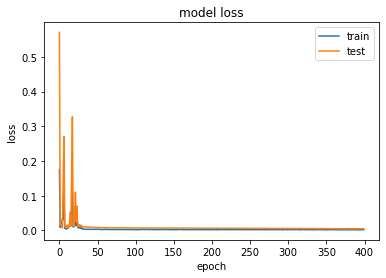

In [25]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [26]:
model_lstm.save_weights("lstm_weights.h5")

In [27]:
model_mix=model_mix(window+1,8)
print(model_mix.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 32)             544       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 64)             4160      
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 300)            438000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 300)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

In [28]:
#Here, we can start the training for 400 epochs:

history_mix=model_mix.fit(X_train,y_train,epochs=400, batch_size=24, validation_data=(X_test, y_test), \
                  verbose=1, callbacks=[learning_rate_reduction],shuffle=False)

Epoch 1/400
15/15 [==============================] - 12s 201ms/step - loss: 0.0537 - val_loss: 0.6374
Epoch 2/400
15/15 [==============================] - 1s 69ms/step - loss: 0.0537 - val_loss: 0.6374
Epoch 3/400
15/15 [==============================] - 1s 71ms/step - loss: 0.0537 - val_loss: 0.6374
Epoch 4/400
15/15 [==============================] - 1s 75ms/step - loss: 0.0537 - val_loss: 0.6374
Epoch 5/400
15/15 [==============================] - 1s 70ms/step - loss: 0.0537 - val_loss: 0.6374
Epoch 6/400
15/15 [==============================] - 1s 79ms/step - loss: 0.0537 - val_loss: 0.6374
Epoch 7/400
15/15 [==============================] - 1s 71ms/step - loss: 0.0537 - val_loss: 0.6374
Epoch 8/400
15/15 [==============================] - 1s 79ms/step - loss: 0.0537 - val_loss: 0.6374
Epoch 9/400
15/15 [==============================] - 1s 74ms/step - loss: 0.0537 - val_loss: 0.6374
Epoch 10/400
15/15 [==============================] - 1s 68ms/step - loss: 0.0537 - val_loss: 0.63

15/15 [==============================] - 1s 66ms/step - loss: 6.9963e-04 - val_loss: 0.0124
Epoch 80/400
15/15 [==============================] - 1s 60ms/step - loss: 7.5959e-04 - val_loss: 0.0123
Epoch 81/400
15/15 [==============================] - 1s 60ms/step - loss: 7.0049e-04 - val_loss: 0.0121
Epoch 82/400
15/15 [==============================] - 1s 61ms/step - loss: 6.6347e-04 - val_loss: 0.0122
Epoch 83/400
15/15 [==============================] - 1s 65ms/step - loss: 7.9754e-04 - val_loss: 0.0124
Epoch 84/400
15/15 [==============================] - 1s 66ms/step - loss: 7.5046e-04 - val_loss: 0.0120
Epoch 85/400
15/15 [==============================] - 1s 65ms/step - loss: 7.5877e-04 - val_loss: 0.0119
Epoch 86/400
15/15 [==============================] - 1s 58ms/step - loss: 8.0155e-04 - val_loss: 0.0121
Epoch 87/400
15/15 [==============================] - 1s 69ms/step - loss: 7.5164e-04 - val_loss: 0.0123
Epoch 88/400
15/15 [==============================] - 1s 66ms/step -

Epoch 155/400
15/15 [==============================] - 1s 60ms/step - loss: 6.6036e-04 - val_loss: 0.0122
Epoch 156/400
15/15 [==============================] - 1s 61ms/step - loss: 6.5865e-04 - val_loss: 0.0122
Epoch 157/400
15/15 [==============================] - 1s 66ms/step - loss: 6.3604e-04 - val_loss: 0.0123
Epoch 158/400
15/15 [==============================] - 1s 61ms/step - loss: 6.3435e-04 - val_loss: 0.0123
Epoch 159/400
15/15 [==============================] - 1s 61ms/step - loss: 7.4554e-04 - val_loss: 0.0124
Epoch 160/400
15/15 [==============================] - 1s 61ms/step - loss: 7.4903e-04 - val_loss: 0.0124
Epoch 161/400
15/15 [==============================] - 1s 60ms/step - loss: 7.0652e-04 - val_loss: 0.0124
Epoch 162/400
15/15 [==============================] - 1s 72ms/step - loss: 6.9853e-04 - val_loss: 0.0124
Epoch 163/400
15/15 [==============================] - 1s 62ms/step - loss: 6.6378e-04 - val_loss: 0.0124
Epoch 164/400
15/15 [=========================

15/15 [==============================] - 1s 81ms/step - loss: 6.0941e-04 - val_loss: 0.0120
Epoch 233/400
15/15 [==============================] - 1s 84ms/step - loss: 5.3967e-04 - val_loss: 0.0120
Epoch 234/400
15/15 [==============================] - 1s 82ms/step - loss: 7.0814e-04 - val_loss: 0.0119
Epoch 235/400
15/15 [==============================] - 1s 82ms/step - loss: 5.2902e-04 - val_loss: 0.0119
Epoch 236/400
15/15 [==============================] - 1s 81ms/step - loss: 6.1430e-04 - val_loss: 0.0120
Epoch 237/400
15/15 [==============================] - 1s 77ms/step - loss: 6.4858e-04 - val_loss: 0.0120
Epoch 238/400
15/15 [==============================] - 1s 93ms/step - loss: 6.6148e-04 - val_loss: 0.0118
Epoch 239/400
15/15 [==============================] - 1s 85ms/step - loss: 5.4992e-04 - val_loss: 0.0118
Epoch 240/400
15/15 [==============================] - 1s 85ms/step - loss: 6.5823e-04 - val_loss: 0.0117
Epoch 241/400
15/15 [==============================] - 1s 82

Epoch 309/400
15/15 [==============================] - 1s 69ms/step - loss: 4.9296e-04 - val_loss: 0.0113
Epoch 310/400
15/15 [==============================] - 1s 63ms/step - loss: 6.7071e-04 - val_loss: 0.0112
Epoch 311/400
15/15 [==============================] - 1s 67ms/step - loss: 6.3006e-04 - val_loss: 0.0113
Epoch 312/400
15/15 [==============================] - 1s 72ms/step - loss: 5.9548e-04 - val_loss: 0.0115
Epoch 313/400
15/15 [==============================] - 1s 64ms/step - loss: 6.5585e-04 - val_loss: 0.0118
Epoch 314/400
15/15 [==============================] - 1s 62ms/step - loss: 6.3263e-04 - val_loss: 0.0120
Epoch 315/400
15/15 [==============================] - 1s 60ms/step - loss: 5.8739e-04 - val_loss: 0.0120
Epoch 316/400
15/15 [==============================] - 1s 62ms/step - loss: 5.6752e-04 - val_loss: 0.0118
Epoch 317/400
15/15 [==============================] - 1s 59ms/step - loss: 5.6175e-04 - val_loss: 0.0117
Epoch 318/400
15/15 [=========================

15/15 [==============================] - 1s 62ms/step - loss: 5.9558e-04 - val_loss: 0.0115
Epoch 387/400
15/15 [==============================] - 1s 61ms/step - loss: 5.5894e-04 - val_loss: 0.0115
Epoch 388/400
15/15 [==============================] - 1s 73ms/step - loss: 5.4950e-04 - val_loss: 0.0117
Epoch 389/400
15/15 [==============================] - 1s 76ms/step - loss: 5.2455e-04 - val_loss: 0.0120
Epoch 390/400
15/15 [==============================] - 1s 77ms/step - loss: 6.3478e-04 - val_loss: 0.0121
Epoch 391/400
15/15 [==============================] - 1s 72ms/step - loss: 5.6354e-04 - val_loss: 0.0120
Epoch 392/400
15/15 [==============================] - 1s 71ms/step - loss: 4.9175e-04 - val_loss: 0.0117
Epoch 393/400
15/15 [==============================] - 1s 72ms/step - loss: 5.5561e-04 - val_loss: 0.0115
Epoch 394/400
15/15 [==============================] - 1s 77ms/step - loss: 5.3904e-04 - val_loss: 0.0114
Epoch 395/400
15/15 [==============================] - 1s 74

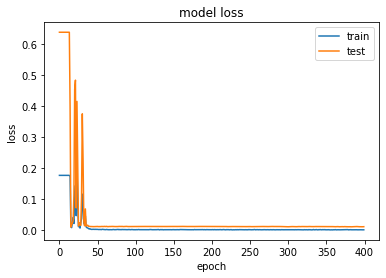

In [29]:
#In the following plot, we can visualize the train and test losses as the training progresses:

plt.plot(history_mix.history['loss'])
plt.plot(history_mix.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [30]:
model_mix.save_weights("mix_weights.h5")

In [31]:
y_pred_train_lstm=model_lstm.predict(X_train)
y_pred_train_mix=model_mix.predict(X_train)

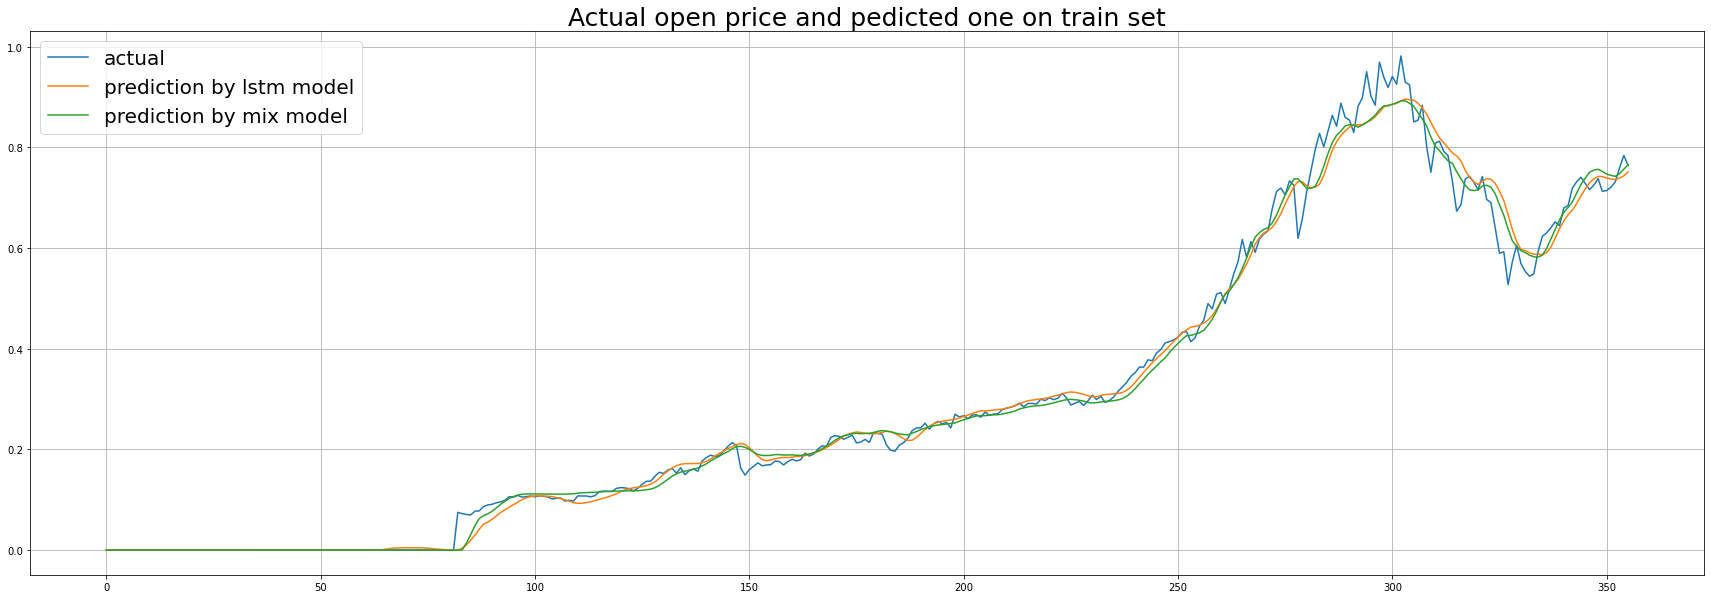

In [32]:
plt.figure(figsize=(30,10))
plt.plot(y_train, label="actual")
plt.plot(y_pred_train_lstm, label="prediction by lstm model")
plt.plot(y_pred_train_mix, label="prediction by mix model")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

Define a Simple Deep Learning Trading Strategy and Compare It with Other Ones
Now that we have defined and trained our deep learning forecasting models, we can develop our investing strategy. The first thing to do will be to predict the value of the S&P 500 index for the next month on the test-set.

In [33]:
y_pred_lstm=model_lstm.predict(X_test)
y_pred_mix=model_mix.predict(X_test)

In [34]:
w_lstm=np.diff(y_pred_lstm.reshape(y_pred_lstm.shape[0]),1)
v_lstm=np.maximum(np.sign(w_lstm),0)

w_mix=np.diff(y_pred_mix.reshape(y_pred_mix.shape[0]),1)
v_mix=np.maximum(np.sign(w_mix),0)

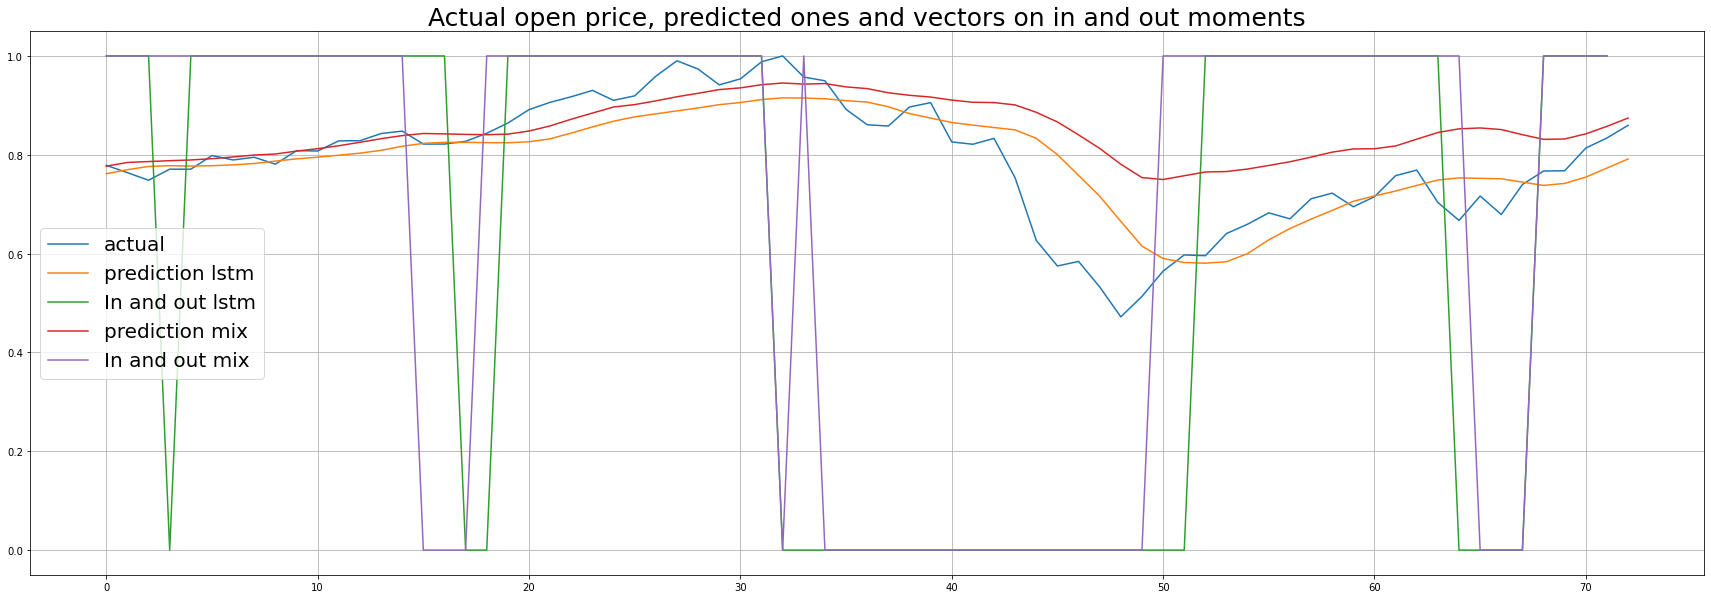

In [35]:
#Here, we plot the in and out months for each month in the test-set.

plt.figure(figsize=(30,10))
plt.plot(y_test, label="actual")
plt.plot(y_pred_lstm, label="prediction lstm")
plt.plot(v_lstm,label="In and out lstm")
plt.plot(y_pred_mix, label="prediction mix")
plt.plot(v_mix,label="In and out mix")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted ones and vectors on in and out moments",fontsize=25)
plt.show()


In [36]:
test=dfm.iloc[-mtest:,:] 
v_bh=np.ones(test.shape[0])
v_ma=test["fd_cm_open"]>test["mv_avg_12"]

In [37]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["quot"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

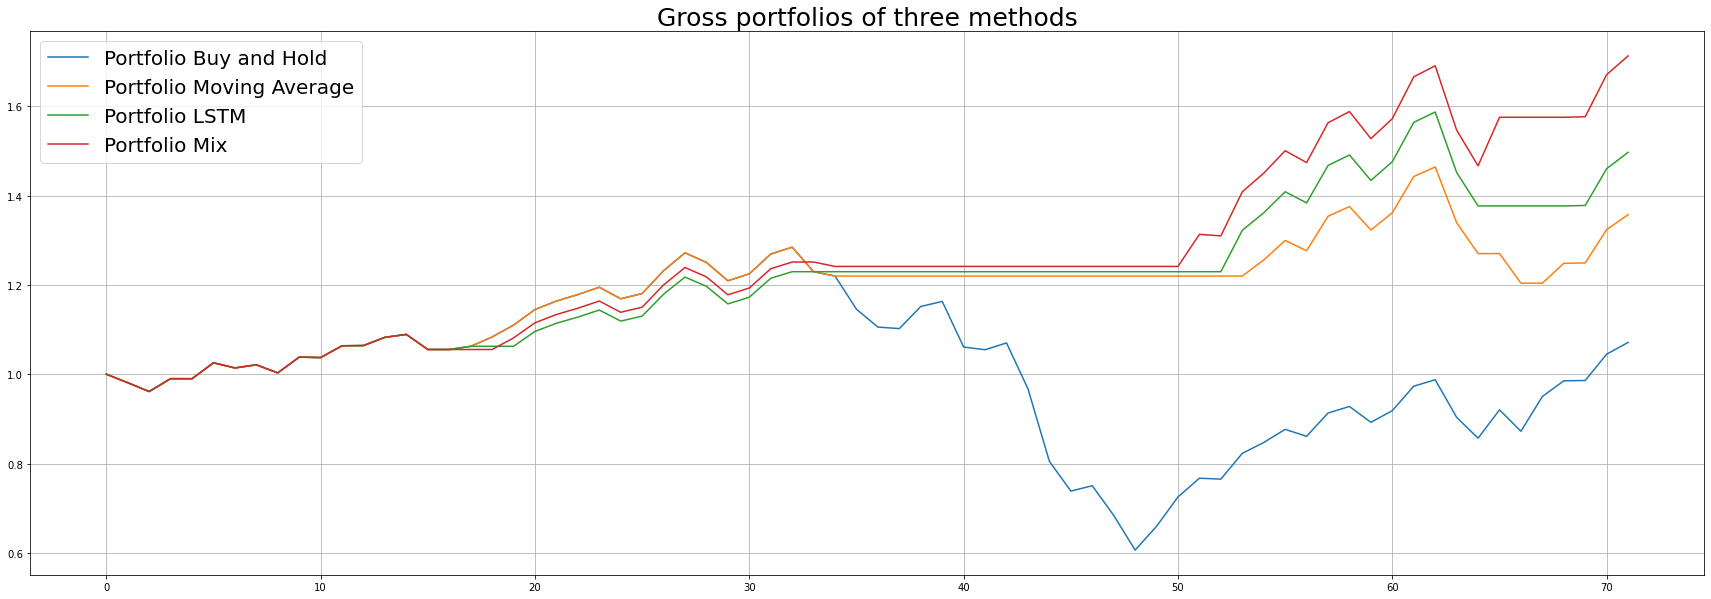

In [38]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.plot(gross_portfolio(test,v_mix),label="Portfolio Mix")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

In [39]:
#Finally, we can see that our deep learning investing strategies performed far better on the test-set than the other two classical investing strategies.

print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/12,str(test.loc[test.index[0],"fd_cm"])[:10],\
      str(test.loc[test.index[-1],"fd_nm"])[:10]))

results=pd.DataFrame({})
results["Method"]=["Buy and hold","Moving average","LSTM","Mix"]

vs=[v_bh,v_ma,v_lstm,v_mix]
results["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]
results["Total net yield"]=[str(round(yield_net(test,vi)[0],2))+" %" for vi in vs]
results["Annual net yield"]=[str(round(yield_net(test,vi)[1],2))+" %" for vi in vs]

print(results)

Test period of 6.00 years, from 2005-03-01 to 2011-03-01 

           Method Total gross yield Annual gross yield Total net yield  \
0    Buy and hold           10.39 %             1.66 %          7.47 %   
1  Moving average           39.86 %             5.75 %         26.14 %   
2            LSTM           54.26 %             7.49 %         36.76 %   
3             Mix            76.5 %             9.93 %         51.87 %   

  Annual net yield  
0           1.21 %  
1           3.95 %  
2           5.36 %  
3           7.21 %  
